In [1]:
import sandy
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.stats import lognorm
import scipy

In [2]:
endf6 = sandy.get_endf6_file("jeff_33", "xs", 922350)

In [3]:
ek = sandy.energy_grids.CASMO12
err = endf6.get_errorr(err=1)
cov = err.get_cov()


 njoy 2016.66  18Nov21                                       03/14/22 23:01:01
 *****************************************************************************

 moder...                                                                 0.0s

 reconr...                                                                0.1s

 ---message from rdf2bw---calculation of angular distribution not installed.

 moder...                                                                 4.1s

 errorr...                                                                4.6s

 processing mat  9228
 ---------------------
  92-U -235 IRSN-CEA   EVAL-DEC14 IRSN-CEA DAM/DEN COLLAB.           

 covariances calculated for  8 reactions and  248 groups                  4.8s
                                                                          6.0s
 *****************************************************************************


In [4]:
cov.data.shape

(1928, 1928)

# Not semi-positive definite:

In [5]:
idx, cov_ = sandy.cov.reduce_size(cov.data)

In [6]:
len(cov_)

1230

In [7]:
E = np.linalg.eig(cov_)[0].real
V = np.linalg.eig(cov_)[1]
E[E<0]=0
len(E[E==0])

566

In [8]:
Cov_ = V.dot(np.diag(E)).dot(np.linalg.inv(V))

In [9]:
E_= np.linalg.eig(Cov_)[0].real

In [10]:
len(E_[E_<0]), E_.min()

(549, -2.07601400896929e-16)

In [11]:
COV = sandy.cov.restore_size(idx, Cov_, cov.data.shape[0])

/home/enrica/sandy/sandy/core/cov.py:2488: ComplexWarning: Casting complex values to real discards the imaginary part
  mat[ni, nonzero_idxs] = mat_reduced[i]


In [12]:
E_COV= np.linalg.eig(COV)[0].real

In [13]:
len(E_COV[E_COV<0]), E_COV.min()

(557, -2.76501352329474e-16)

# Normal

In [14]:
df = pd.DataFrame(np.random.multivariate_normal(np.ones(len(cov.data)), COV, size=10000))

/home/enrica/anaconda3/envs/sandy-devel/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)




mean: [0.9949891841817209, 1.0020712878150115]


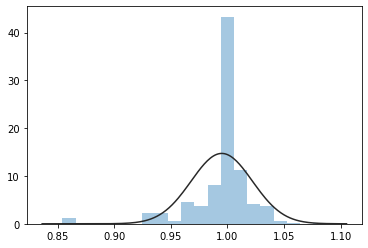

In [15]:
sns.distplot(x=df.iloc[0,:], bins= 20, fit=norm, kde=False)
print(f"""

mean: {[df.iloc[0,:].mean(), df.iloc[-1,:].mean()]}""")

In [16]:
df.values.min()

0.28805011918149703

In [17]:
E = np.linalg.eig(df.cov())[0].real

In [18]:
E[E<0]

array([], dtype=float64)

# LogNormal

In [19]:
COV_lognorm = cov.data.apply(np.exp) - 1 * 1 * 1

In [20]:
std = cov.std

In [21]:
normal_equivalent_mean = np.log(np.ones(len(cov.data))) - std**2/2

In [22]:
df = pd.DataFrame(np.random.multivariate_normal(normal_equivalent_mean, COV_lognorm, size=10000)).apply(np.exp)

/home/enrica/anaconda3/envs/sandy-devel/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


/home/enrica/anaconda3/envs/sandy-devel/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)




mean: [1.0377929699468778, 1.0056949887204487]


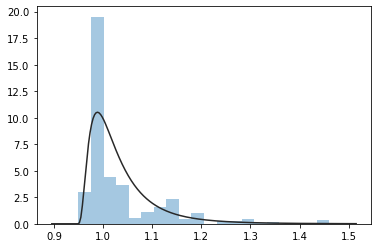

In [23]:
sns.distplot(x=df.iloc[0,:], bins= 20, fit=lognorm, kde=False)
print(f"""

mean: {[df.iloc[0,:].mean(), df.iloc[-1,:].mean()]}""")

In [24]:
df.values.min()

0.4628296688947209

In [25]:
E = np.linalg.eig(df.cov())[0].real

In [26]:
E[E<0]

array([], dtype=float64)

# Now implemented in CategoryCov:
- ### Normal

In [27]:
df = cov.sampling(10000,tolerance=0).data



mean: [1.003270648119446, 1.0033273440700738]


/home/enrica/anaconda3/envs/sandy-devel/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


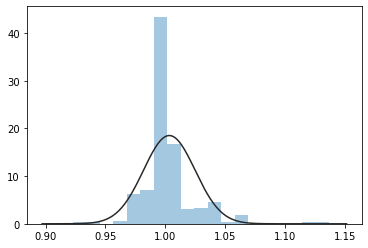

In [28]:
sns.distplot(x=df.iloc[0,:], bins= 20, fit=norm, kde=False)
print(f"""

mean: {[df.iloc[0,:].mean(), df.iloc[-1,:].mean()]}""")

In [29]:
df.values.min()

0.29435048099142935

In [30]:
E = np.linalg.eig(df.cov())[0].real

In [31]:
len(E[E<0]), E.min()

(560, -7.663676766506462e-17)

# UPDATE VERSION: random.Generator
- ### Normal

In [32]:
my_generator = np.random.default_rng()

In [33]:
df = pd.DataFrame(my_generator.multivariate_normal(np.ones(len(cov.data)), COV, size=10000))



mean: [0.9815328510925309, 0.9895837041283368]


/home/enrica/anaconda3/envs/sandy-devel/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


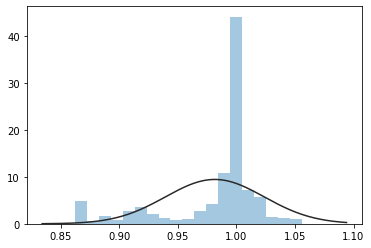

In [34]:
sns.distplot(x=df.iloc[0,:], bins= 20, fit=norm, kde=False)
print(f"""

mean: {[df.iloc[0,:].mean(), df.iloc[-1,:].mean()]}""")

In [35]:
E, V = np.linalg.eig(df.cov())

In [36]:
E_origin, V_origin = np.linalg.eig(COV)

In [37]:
pd.DataFrame([E.real,E_origin.real]).T

,0,1
0,2.66458e+00,2.66075e+00
1,1.33032e+00,1.31641e+00
2,4.00038e-01,3.93323e-01
3,1.72862e-01,1.70611e-01
4,1.08498e-01,1.08341e-01
...,...,...
1923,1.95223e-16,0.00000e+00
1924,1.95223e-16,0.00000e+00
1925,1.95460e-16,0.00000e+00
1926,1.96679e-16,0.00000e+00


In [38]:
df.values.min()

0.3006519442290201

In [39]:
E = np.linalg.eig(df.cov())[0].real

In [40]:
E[E<0]

array([], dtype=float64)

- ### Lognormal 

In [41]:
COV_lognorm = cov.data.apply(np.exp) - 1 * 1 * 1

In [42]:
std = cov.std

In [43]:
normal_equivalent_mean = np.log(np.ones(len(cov.data))) - std**2/2

In [44]:
df = pd.DataFrame(my_generator.multivariate_normal(normal_equivalent_mean, COV_lognorm, size=10000)).apply(np.exp)

/home/enrica/anaconda3/envs/sandy-devel/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


/home/enrica/anaconda3/envs/sandy-devel/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)




mean: [1.0006900780734822, 0.9884966538764277]


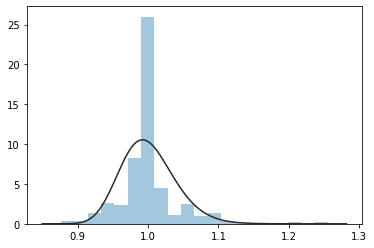

In [45]:
sns.distplot(x=df.iloc[0,:], bins= 20, fit=lognorm, kde=False)
print(f"""

mean: {[df.iloc[0,:].mean(), df.iloc[-1,:].mean()]}""")

In [46]:
df.values.min()

0.48246672286010367

In [47]:
E = np.linalg.eig(df.cov())[0].real

In [48]:
E[E<0]

array([], dtype=float64)

# Compare sampling unit tests with new method:

 - ### Test 1

In [49]:
sandy.CategoryCov([[1, 0.4],[0.4, 1]]).sampling(3, seed=11)

             0            1
0 -7.49455e-01 -2.13159e+00
1  1.28607e+00  1.10684e+00
2  1.48457e+00  9.00879e-01

In [50]:
sandy.Samples(my_generator.multivariate_normal(np.ones(2), [[1, 0.4],[0.4, 1]], size=3))

            0           1
0 2.20264e+00 1.62426e+00
1 2.02974e+00 1.81370e+00
2 1.53801e+00 7.36677e-01

 - ### Test 2

In [51]:
sample = sandy.CategoryCov([[1, 0.4],[0.4, 1]]).sampling(1000000, seed=11)
sample.data.cov()

,0,1
0,9.98662e-01,3.99417e-01
1,3.99417e-01,9.98156e-01


In [52]:
sample = sandy.Samples(my_generator.multivariate_normal(np.ones(2), [[1, 0.4],[0.4, 1]], size=1000000))
sample.data.cov()

,0,1
0,1.00013e+00,4.01253e-01
1,4.01253e-01,1.00391e+00


 - ### Test 3

In [53]:
sandy.CategoryCov([[1, -2],[-2, 3]]).sampling(3, seed=11, tolerance=0)

             0           1
0 -8.92988e-01 4.06292e+00
1  1.30954e+00 4.99148e-01
2  1.52432e+00 1.51631e-01

In [54]:
cov = sandy.CategoryCov([[1, -2],[-2, 3]])
E, V = cov.eig(tolerance=0) 
cov_semipositive = V.dot(np.diag(E)).dot(np.linalg.inv(V))
sandy.Samples(my_generator.multivariate_normal(np.ones(2), cov_semipositive, size=3))

             0            1
0  1.85268e+00 -3.79671e-01
1 -1.49973e+00  5.04465e+00
2  1.76968e+00 -2.45370e-01

- ### Test 4

In [55]:
sandy.CategoryCov([[1, -2],[-2, 3]]).sampling(1000000, seed=11, tolerance=0).data.cov()

,0,1
0,1.16925e+00,-1.89189e+00
1,-1.89189e+00,3.06115e+00


In [56]:
cov = sandy.CategoryCov([[1, -2],[-2, 3]])
E, V = cov.eig(tolerance=0) 
cov_semipositive = V.dot(np.diag(E)).dot(np.linalg.inv(V))
sandy.Samples(my_generator.multivariate_normal(np.ones(2), cov_semipositive, size=1000000)).data.cov()

,0,1
0,1.16969e+00,-1.89260e+00
1,-1.89260e+00,3.06230e+00


## Behaviour with non-PSD

In [57]:
samples = sandy.Samples(my_generator.multivariate_normal(np.ones(2), cov.data, size=1000000)).data.cov()

/home/enrica/anaconda3/envs/sandy-devel/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


In [58]:
np.linalg.eig(samples)[0]

array([0.23630504, 4.24497055])

In [59]:
np.linalg.eig(cov.data)[0]

array([-0.23606798,  4.23606798])

In [60]:
samples = sandy.Samples(my_generator.multivariate_normal(np.ones(3), [[1,-2, 9],[0,-2,2],[9,0,3]], size=1000000, tol=1e-4)).data.cov()

/home/enrica/anaconda3/envs/sandy-devel/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


In [61]:
np.linalg.eig(samples)[0]

array([11.28730709,  7.40914717,  1.43538874])

In [62]:
np.linalg.eig([[1,-2, 9],[0,-2,2],[9,0,3]])[0]

array([10.89996032, -7.41529786, -1.48466246])

## Bigger matrices
##### Effect of negative eigenvalues on bigger matrices (i.e. matrices in which there are more negative eigenvalues even if they are always expected to be ~50%)

In [63]:
F_endf6 = sandy.get_endf6_file("jeff_33", "xs", 451030) 

In [64]:
F_cov = sandy.CategoryCov(sandy.XsCov.from_endf6(F_endf6))

In [65]:
F_E = F_cov.eig()[0]
min(F_E), max(F_E)

(-20.29417923096467, 120.92336534985974)

In [66]:
sandy_samples = F_cov.sampling(10000, seed=11, tolerance=0)
sandy_cov = sandy.CategoryCov(sandy_samples.data.cov())
sandy_eig = sandy_cov.eig()[0]
min(sandy_eig), max(sandy_eig)

(-5.219466686119712e-15, 120.55021578117396)

In [67]:
generator_samples = sandy.Samples(my_generator.multivariate_normal(np.ones(F_cov.data.shape[0]), F_cov.data, size=10000))
generator_cov = sandy.CategoryCov(generator_samples.data.cov())
generator_eig = generator_cov.eig()[0]
min(generator_eig), max(generator_eig)

/home/enrica/anaconda3/envs/sandy-devel/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


(8.883127316110237e-15, 119.57946814420535)

In [68]:
EE, VV = F_cov.eig()
EE[EE<0] = 0
tmp_cov = VV.dot(np.diag(EE)).dot(np.linalg.inv(VV))
generator_samples_0 = sandy.Samples(my_generator.multivariate_normal(np.ones(F_cov.data.shape[0]), tmp_cov, size=10000))
generator_cov_0 = sandy.CategoryCov(generator_samples_0.data.cov())
generator_eig_0 = generator_cov_0.eig()[0]
min(generator_eig_0), max(generator_eig_0)

(5.449543757252468e-15, 123.11185922746436)

In [69]:
Delta_sandy_original = abs(F_cov.data.values - sandy_cov.data.values).reshape(F_cov.data.shape[0]**2,1)
Delta_generator_original = abs(F_cov.data.values - generator_cov.data.values).reshape(F_cov.data.shape[0]**2,1)
Delta_generator0_original = abs(generator_cov_0.data.values - F_cov.data.values).reshape(F_cov.data.shape[0]**2,1)

In [70]:
tol = 1e-6*max(F_E)

In [71]:
len(Delta_sandy_original[Delta_sandy_original>tol])/F_cov.data.shape[0]**2*100

78.54411299235683

In [72]:
len(Delta_generator_original[Delta_generator_original>tol])/F_cov.data.shape[0]**2*100

80.38771073209459

In [73]:
len(Delta_generator0_original[Delta_generator0_original>tol])/F_cov.data.shape[0]**2*100

78.49222451108079